In [2]:
from gevent import monkey
monkey.patch_all(thread=False, select=False)
from locust.env import Environment
from kubernetes import client, config

from prometheus_api_client import PrometheusConnect

from ray.rllib.env.policy_client import PolicyClient
import pandas as pd
import time
import numpy as np
from collections import OrderedDict
from gymnasium.spaces import Discrete, Dict, MultiDiscrete, Tuple, Box
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.dqn import DQNConfig

import ssl
import random
import logging
import ray
from ray.rllib.algorithms.algorithm import Algorithm
from ray.rllib.env.policy_server_input import PolicyServerInput
from locust import HttpUser, task, constant, constant_throughput, events
from locust.shape import LoadTestShape

ssl._create_default_https_context = ssl._create_unverified_context
from itertools import product
import time


DEPLOYMENT_NAME = "teastore-webui"
NAMESPACE = "app2scale-test"

OBSERVATION_SPACE =Box(low=np.array([1, 4, 4, 0, 0]), high=np.array([3, 9, 9, 500, 500]), dtype=np.float32)

"""
    # replica : 1,2,3,4,5,6 -> 0,1,2,3,4,5 + 1
    # cpu : 4,5,6,7,8,9 -> 0,1,2,3,4,5   +   4
    # heap : 4,5,6,7,8,9 -> 0,1,2,3,4,5   +   4
"""

ACTION_SPACE = Discrete(108) # index of the possible states
replica = [1, 2, 3]
cpu = [4, 5, 6, 7, 8, 9]
heap = [4, 5, 6, 7, 8, 9]

config_dqn = (DQNConfig()
          .environment(
              env=None,
              action_space=ACTION_SPACE,
              observation_space=OBSERVATION_SPACE)

          .training(model={"fcnet_hiddens": [64,64]},
              gamma=0.99,
              lr=1e-05,
              train_batch_size=256)

          .debugging(log_level="INFO")
          .evaluation(off_policy_estimation_methods={})
          
          )


config_dqn.rl_module(_enable_rl_module_api=False)
config_dqn.training(_enable_learner_api=False)
algo = config_dqn.build() 


path_to_checkpoint = "/Users/hasan.nayir/ray_results/DQN_None_2024-02-27_16-08-46u3b9he5e/checkpoints/checkpoint_004000"
algo.restore(path_to_checkpoint)

2024-02-27 16:46:02,120	INFO policy.py:1285 -- Policy (worker=local) running on CPU.
2024-02-27 16:46:02,121	INFO torch_policy.py:184 -- Found 0 visible cuda devices.
2024-02-27 16:46:02,129	INFO util.py:118 -- Using connectors:
2024-02-27 16:46:02,130	INFO util.py:119 --     AgentConnectorPipeline
        ObsPreprocessorConnector
        StateBufferConnector
        ViewRequirementAgentConnector
2024-02-27 16:46:02,131	INFO util.py:120 --     ActionConnectorPipeline
        ConvertToNumpyConnector
        NormalizeActionsConnector
        ImmutableActionsConnector
2024-02-27 16:46:02,131	INFO rollout_worker.py:2000 -- Built policy map: <PolicyMap lru-caching-capacity=100 policy-IDs=['default_policy']>
2024-02-27 16:46:02,132	INFO rollout_worker.py:2001 -- Built preprocessor map: {'default_policy': None}
2024-02-27 16:46:02,132	INFO rollout_worker.py:761 -- Built filter map: defaultdict(<class 'ray.rllib.utils.filter.NoFilter'>, {})
Install gputil for GPU system monitoring.
2024-02-27 

In [11]:
ACTION_SPACE = Discrete(108) # index of the possible states
replica = [1, 2, 3]
cpu = [4, 5, 6, 7, 8, 9]
heap = [4, 5, 6, 7, 8, 9]

POSSIBLE_STATES = np.array(list(product(replica, cpu, heap)))

In [5]:
OBSERVATION_SPACE.sample()

array([  2.9428666,   5.5114183,   6.7960362, 483.2061   , 163.23544  ],
      dtype=float32)

In [24]:
test_step = 1
for i in range(test_step):
    obs = np.array([  3,   9,   9, 5000  , 0 ],dtype=np.float32)/np.array([3,9,9,168,168])
    action = algo.compute_single_action(obs, full_fetch=True)
    print(action)
    print(POSSIBLE_STATES[action[0]])


(22, [], {'q_values': array([153.70984, 211.30504, 195.40848, 196.78154, 245.4486 , 148.25154,
       155.30702, 175.69131, 241.31253, 240.56035, 262.9794 , 261.4909 ,
       237.18048, 248.72517, 227.13641, 177.09846, 212.45862, 203.562  ,
       216.98065, 261.0282 , 211.18938, 198.7151 , 263.53235, 245.68216,
       210.74355, 248.59052, 243.39795, 143.99661, 262.9657 , 221.83119,
       212.10228, 220.77121, 241.88437, 263.43744, 258.1985 , 233.82278,
       262.9962 , 216.56909, 252.77289, 207.316  , 217.37224, 216.54128,
       199.09703, 221.68907, 219.40297, 196.64442, 171.44589, 219.336  ,
       178.22217, 160.07834, 152.3945 , 148.68039, 191.28673, 154.88808,
       198.41615, 166.751  , 185.69702, 190.62845, 245.52345, 236.87395,
       173.79813, 223.8711 , 256.3898 , 197.05498, 263.39334, 263.37585,
       241.34451, 189.36383, 235.95355, 226.71202, 199.07773, 204.72194,
       225.27208, 131.35904, 238.94843, 122.28483, 228.49704, 219.16463,
       250.02069, 229.70522, 

97


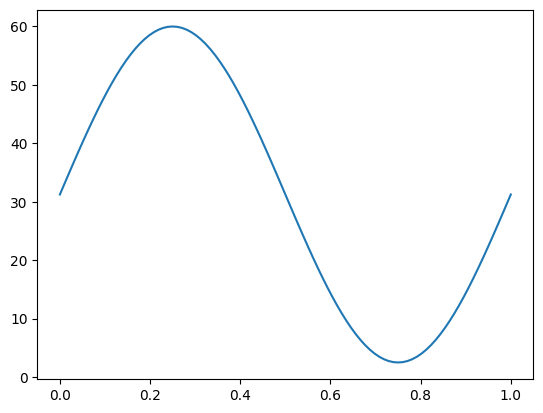

In [20]:
import numpy as np
import matplotlib.pyplot as plt
t = np.linspace(0, 1, 97) 

sinus_dalga = 230 * np.sin(2 * np.pi * 1 * t) +250
print(len(sinus_dalga))
plt.plot(t, sinus_dalga/8)

In [19]:
sinus_dalga

array([250.        , 265.04271972, 280.02102421, 294.87077406,
       309.52838037, 323.93107702, 338.01718944, 351.72639875,
       365.        , 377.78115359, 390.01512867, 401.64953747,
       412.63455967, 422.92315572, 432.47126827, 441.23801083,
       449.18584287, 456.28073055, 462.49229248, 467.79392978,
       472.16294005, 475.58061449, 478.03231812, 479.50755234,
       480.        , 479.50755234, 478.03231812, 475.58061449,
       472.16294005, 467.79392978, 462.49229248, 456.28073055,
       449.18584287, 441.23801083, 432.47126827, 422.92315572,
       412.63455967, 401.64953747, 390.01512867, 377.78115359,
       365.        , 351.72639875, 338.01718944, 323.93107702,
       309.52838037, 294.87077406, 280.02102421, 265.04271972,
       250.        , 234.95728028, 219.97897579, 205.12922594,
       190.47161963, 176.06892298, 161.98281056, 148.27360125,
       135.        , 122.21884641, 109.98487133,  98.35046253,
        87.36544033,  77.07684428,  67.52873173,  58.76